# 8. Analysis of algorithm aggregation

In this last notebook, I will present how you can use embedded voting for **algorithms aggregation** and why this can give better results than *trivial rules* and *maximum likelihood optimizer*.

In [1]:
import embedded_voting as ev
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
np.random.seed(42)

Let's first define the rules that we want to compare. Here I only took **SumScores**, **ProductScores**, **SVDNash** and **SVDSum**, as in our paper. I also added **MLE**.

In [2]:
list_rules = [ev.SVDNash(), ev.SVDSum(), 
              ev.SumScores(), ev.ProductScores()]

list_names = ["SVDNash", "SVDSum", 
              "SumScores", "ProdcutScores",
              "MLERule", "MLERule (1000)",]

## Online Learning

The first point of interest of our rules is that they work well, even with a **small training set**. On its side, **maximum likelihood optimization** works well, but it needs a lot of training samples.

Let's define a set of algorithm with a big group of $25$ similar algorithms, a smaller group of $7$ algorithm and $3$ semi independent algorithms.

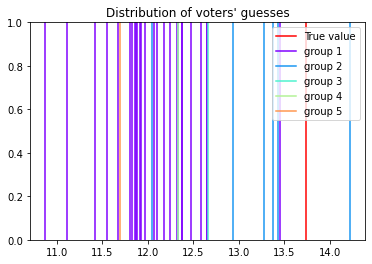

In [3]:
groups_sizes = [25, 7, 1, 1, 1]
features = [[1, 0, 0], [0, 1, 0], [1, 0, 1], [0, 1, 1], [0, 0, 1]]

generator = ev.GroupedMixGenerator(groups_sizes, features)
generator.set_group_noise(8)
generator.set_independent_noise(0.5)
generator.plot_scores()

In this notebook, we will run experiments with $20$ candidates.

In [4]:
n_voters = int(np.sum(groups_sizes))
n_candidates = 20

The following cell contains the code to track the evolution of the mean welfare of the candidate selected by each rule, depending on the number of samples in the **training set**.

In [5]:

max_training = 500

def online_learning():
    results = []
    tab_training = []
    total_training = np.zeros((n_voters, 0))
    n_training = 0

    while n_training < max_training:
        truth, scores = generator.sample_scores(20)

        # We get the real welfare of each candidate using a SumScoresProfile 
        true_profile = ev.Profile(n_candidates, 0)
        true_profile.add_voter([], truth)
        target = ev.SumScores(true_profile)
        welfare = target.welfare_

        # We create the profile of voters-algorithms
        profile = ev.AutoProfile(n_candidates, 0)
        profile.add_voters_auto(scores, total_training)

        # We get the preformance of every rule
        n_training = total_training.shape[1]
        results_i = []
        for rule in list_rules:
            w = rule(profile).winner_
            results_i.append(welfare[w])

        # We get the performance of MLE
        profile = ev.AutoProfile(n_candidates, n_voters)
        profile.add_voters_cov(scores, total_training)
        w = ev.MLERule(profile).winner_
        results_i.append(welfare[w])

        results.append(results_i)
        tab_training.append(n_training)

        total_training = np.concatenate([total_training, generator.sample_scores(50)[1]], axis=1)

    results = np.array(results).T
    return results

We can run it **one time**, but the plot we obtain is not very informative.

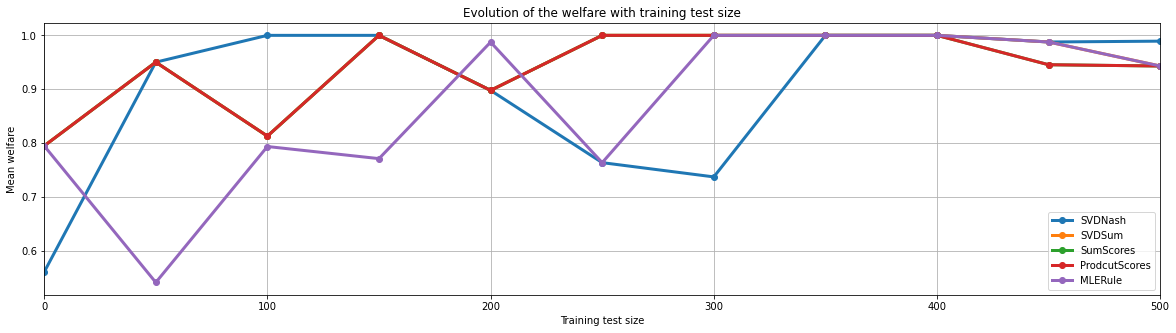

In [6]:
results = online_learning()

n_steps = max_training//50 +1
tab_training = [50*i for i in range(n_steps)]

fig = plt.figure(figsize=(20, 5))

for i, r in enumerate(results):
    plt.plot(tab_training, r, 'o-', label=list_names[i], linewidth=3)
    
plt.xlim(0,max_training)
plt.xlabel("Training test size")
plt.ylabel("Mean welfare")
plt.title("Evolution of the welfare with training test size")
plt.legend()
plt.grid(0.3)
plt.legend()
plt.show()

That's why we are running it $500$ times and averaging the results for each rule.

We obtain a much better plot, on which we can see that **SVDNash** outperform any other rule, and particularly **MLERule**. However, with a lot of training samples, **MLERule** is as good as **SVDNash**.

In [7]:
results = np.zeros((len(list_rules)+1, n_steps))

n_trys = 500
for i in tqdm(range(n_trys)):
    results += online_learning()

results = results/n_trys

100%|██████████| 500/500 [07:18<00:00,  1.14it/s]


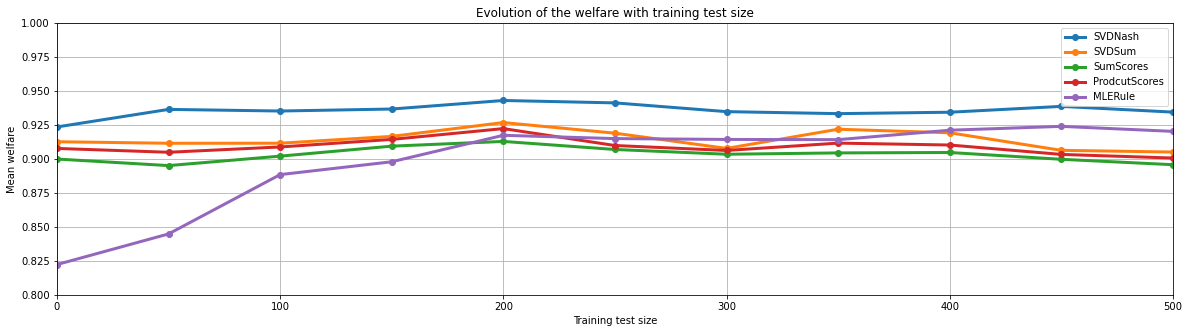

In [8]:
fig = plt.figure(figsize=(20, 5))
for i, r in enumerate(results):
    plt.plot(tab_training, r, 'o-', label=list_names[i], linewidth=3)
    
plt.ylim(0.8, 1)
plt.xlim(0,max_training)
plt.xlabel("Training test size")
plt.ylabel("Mean welfare")
plt.title("Evolution of the welfare with training test size")
plt.legend()
plt.grid(0.3)
plt.show()

## Evolution with the noise

We can do a similar experiment, but instead of changing the size of the training set, we can change the **noise** of the generator, either the **group noise** or the **independent noise**. 

In these experiments, the size of the training set is $100$, but for maximum likelihood, we also look at what happens with a size of $1000$.

In [9]:
def noise_evolution(noise_kind="group", min_noise=0, max_noise=20, training_size=100, training_size_mle=[]):
    results = []
    
    noises = np.linspace(min_noise, max_noise, 20)
    for noise in noises:
        if noise_kind == "group":
            generator.set_group_noise(noise)
        elif noise_kind == "independent":
            generator.set_independent_noise(noise)
        else:
            raise ValueError("bad parameter")
            
        truth, scores = generator.sample_scores(20)
        _, training = generator.sample_scores(training_size)

        # We get the real welfare of each candidate using a SumScoresProfile 
        true_profile = ev.Profile(n_candidates, 0)
        true_profile.add_voter([], truth)
        target = ev.SumScores(true_profile)
        welfare = target.welfare_

        # We create the profile of voters-algorithms
        profile = ev.AutoProfile(n_candidates, 0)
        profile.add_voters_auto(scores, training)

        # We get the preformance of every rule
        results_i = []
        for rule in list_rules:
            w = rule(profile).winner_
            results_i.append(welfare[w])

        # We get the performance of MLE
        profile = ev.AutoProfile(n_candidates, n_voters)
        profile.add_voters_cov(scores, training)
        w = ev.MLERule(profile).winner_
        results_i.append(welfare[w])
        
        for size in training_size_mle:
            _, training = generator.sample_scores(size)
            # We get the performance of MLE
            profile.add_voters_cov(scores, training)
            w = ev.MLERule(profile).winner_
            results_i.append(welfare[w])

        results.append(results_i)

    results = np.array(results).T
    return results

### Group noise

We can see that when the **group noise** increases, the efficiency of all rules decreases. Moreover, the gap between **SVDNash** and other rules increases with the noise.

We also see that **MLE** needs $1000$ training samples instead of $100$ to obtain the same mean welfare than **SVDNash**.

In [10]:
min_noise = 0
max_noise = 20
results = np.zeros((len(list_rules)+2, 20))

generator.set_independent_noise(0.5)

n_trys = 200
for i in tqdm(range(n_trys)):
    results += noise_evolution("group", min_noise, max_noise, training_size_mle=[1000])

results = results/n_trys

100%|██████████| 200/200 [25:32<00:00,  7.66s/it]


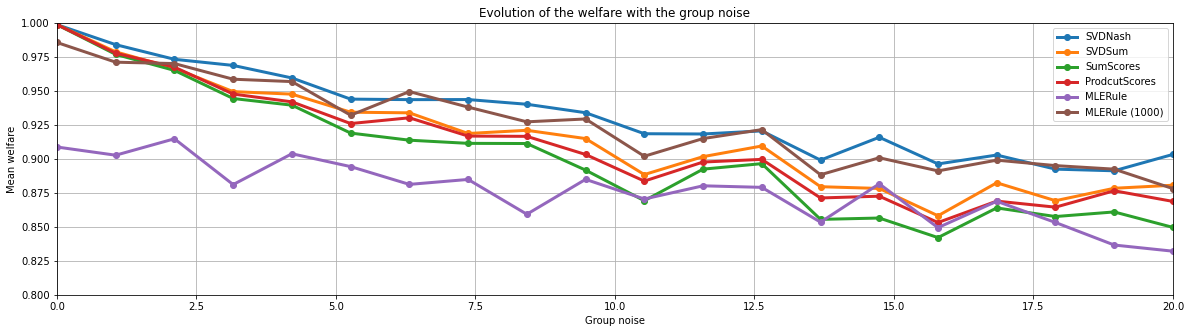

In [11]:
tab_training = np.linspace(min_noise, max_noise, 20)

fig = plt.figure(figsize=(20, 5))

for i, r in enumerate(results):
    plt.plot(tab_training, r, 'o-', label=list_names[i], linewidth=3)
    
plt.ylim(0.8, 1)
plt.xlim(0,max_noise)
plt.legend()
plt.xlabel("Group noise")
plt.ylabel("Mean welfare")
plt.title("Evolution of the welfare with the group noise")
plt.grid(0.3)
plt.legend()
plt.show()

### Independent noise

As we can see on the following plot, the bigger is the **independent noise**, the smaller the gap between the different rules. Indeed, when there is a lot of noise, there is no mutual information left to exploit: scores are too random.

In [12]:
min_noise = 0
max_noise = 10
results = np.zeros((len(list_rules)+2, 20))

generator.set_group_noise(10)

n_trys = 200
for i in tqdm(range(n_trys)):
    results += noise_evolution("independent", min_noise, max_noise, training_size_mle=[1000])

results = results/n_trys

100%|██████████| 200/200 [25:47<00:00,  7.74s/it]


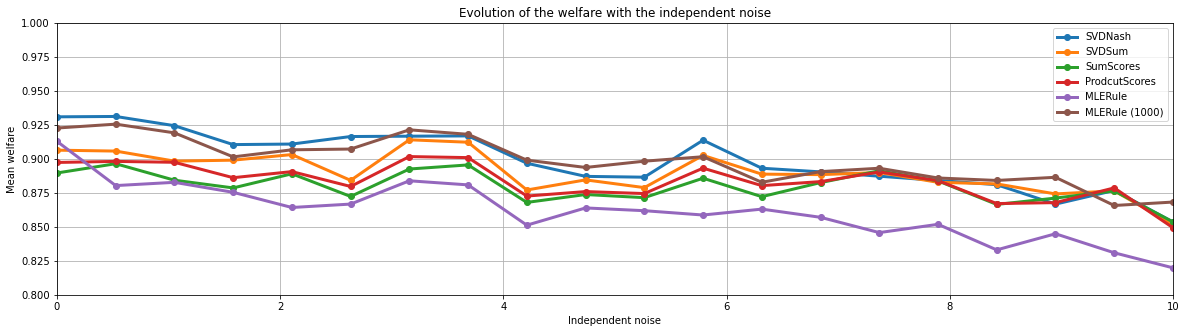

In [13]:
tab_training = np.linspace(min_noise, max_noise, 20)

fig = plt.figure(figsize=(20, 5))

for i, r in enumerate(results):
    plt.plot(tab_training, r, 'o-', label=list_names[i], linewidth=3)
    
plt.ylim(0.8, 1)
plt.xlim(0,max_noise)
plt.legend()
plt.xlabel("Independent noise")
plt.ylabel("Mean welfare")
plt.title("Evolution of the welfare with the independent noise")
plt.grid(0.3)
plt.legend()
plt.show()